## Library Setup and Dependencies

In [137]:
## Library Imports and Configurations
from typing import Tuple
import warnings
import gzip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (TensorDataset, DataLoader, random_split)
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore', category=FutureWarning)
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

## LeNet-5: Original Architecture Implementation
This implementation follows the original LeNet-5 architecture as proposed by Yann LeCun et al. (1989). We maintain the classic design choices:
- Input: 32x32 grayscale images
- Conv1: 6 feature maps (5x5 kernel)
- Avg pooling layers instead of max pooling
- Tanh activation functions
- Final output: 10 classes

Note: We deliberately keep the original architecture without modern improvements to:
- Demonstrate the historical significance
- Provide a clear baseline for understanding
- Keep implementation straightforward for educational purposes

In [140]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1*1*120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Reshape input from [batch_size, 784] to [batch_size, 1, 28, 28]
        x = x.view(-1, 1, 28, 28)
        
        x = self.act1(self.conv1(x))  # Output: 6x28x28
        x = self.pool1(x)             # Output: 6x14x14
        x = self.act2(self.conv2(x))  # Output: 16x10x10
        x = self.pool2(x)             # Output: 16x5x5
        x = self.act3(self.conv3(x))  # Output: 120x1x1
        x = self.flat(x)
        x = self.act4(self.fc1(x))    # Output: 84
        x = self.fc2(x)               # Output: 10
        return x

## Data Loading and Processing

In [143]:
def load_data() -> Tuple[TensorDataset, TensorDataset, TensorDataset]:
    
    ((data_train, label_train), (data_test, label_test)) = torch.load(gzip.open('mnist.pkl.gz'))
    
    # Convert to float32
    data_train, label_train = data_train.float(), label_train.float()
    data_test, label_test = data_test.float(), label_test.float()
    
    # Split training data into train and validation (80-20)
    train_size = int(0.8 * len(data_train))
    val_size = len(data_train) - train_size
    
    full_train_dataset = TensorDataset(data_train, label_train)
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    test_dataset = TensorDataset(data_test, label_test)
    
    return train_dataset, val_dataset, test_dataset

## Model training 

In [146]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0
    
    # Get device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for data, labels in train_loader:
            # Move data to device
            data, labels = data.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels_max = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels_max).sum().item()
        
        train_accuracy = 100 * correct / total
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        
        # Store metrics for plotting
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

## Evaluation function

In [149]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in data_loader:
            # Move data to device
            data, labels = data.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(data)
            loss += criterion(outputs, labels).item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, labels_max = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == labels_max).sum().item()
    
    accuracy = 100 * correct / total
    return loss / len(data_loader), accuracy

## Hyperparameter Optimization

In [152]:
def grid_search_lenet(num_epochs = 20):
    # Define hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes = [32, 64, 128]
    
    best_val_accuracy = 0
    best_hyperparams = {}
    results = []

    # Load data once
    train_dataset, val_dataset, test_dataset = load_data()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Grid search
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print("================")
            print(f"\nTesting with learning_rate={lr}, batch_size={batch_size}")
            
            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize model and optimizer
            model = LeNet5().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Train model using train_model function
            train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)
            
            # Get final validation accuracy
            _, val_accuracy = evaluate_model(model, val_loader, criterion, device)
            
            # Store results
            result = {
                'lr': lr,
                'batch_size': batch_size,
                'final_val_accuracy': val_accuracy,
            }
            results.append(result)
            
            # Update best model if necessary
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_hyperparams = {
                    'learning_rate': lr,
                    'batch_size': batch_size
                }
                

    print("\nGrid Search Results:")
    print("Results for each configuration:")
    for result in results:
        print(f"lr={result['lr']}, batch_size={result['batch_size']}: {result['final_val_accuracy']:.2f}%")
    print(f"\nBest validation accuracy: {best_val_accuracy:.2f}%")
    print(f"Best hyperparameters: {best_hyperparams}")
    
    return results, best_hyperparams

# Run the complete pipeline


Testing with learning_rate=0.01, batch_size=32
Epoch [1/20], Train Loss: 0.2864, Train Accuracy: 91.37%, Val Loss: 0.2630, Val Accuracy: 91.73%
Epoch [2/20], Train Loss: 0.2068, Train Accuracy: 93.92%, Val Loss: 0.2002, Val Accuracy: 94.34%
Epoch [3/20], Train Loss: 0.1893, Train Accuracy: 94.43%, Val Loss: 0.2111, Val Accuracy: 93.92%
Epoch [4/20], Train Loss: 0.1885, Train Accuracy: 94.47%, Val Loss: 0.2122, Val Accuracy: 93.82%
Epoch [5/20], Train Loss: 0.1837, Train Accuracy: 94.71%, Val Loss: 0.1938, Val Accuracy: 94.60%
Epoch [6/20], Train Loss: 0.1703, Train Accuracy: 95.04%, Val Loss: 0.1709, Val Accuracy: 95.22%
Epoch [7/20], Train Loss: 0.1677, Train Accuracy: 95.10%, Val Loss: 0.1674, Val Accuracy: 95.45%
Epoch [8/20], Train Loss: 0.1772, Train Accuracy: 94.86%, Val Loss: 0.2045, Val Accuracy: 94.21%
Epoch [9/20], Train Loss: 0.1782, Train Accuracy: 94.93%, Val Loss: 0.1957, Val Accuracy: 94.10%
Epoch [10/20], Train Loss: 0.1813, Train Accuracy: 94.72%, Val Loss: 0.1663, Va

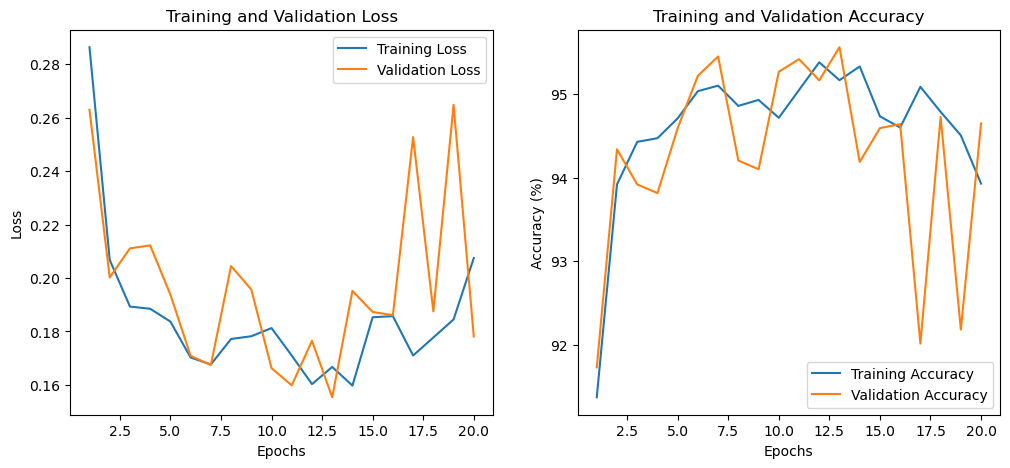


Testing with learning_rate=0.01, batch_size=64
Epoch [1/20], Train Loss: 0.2406, Train Accuracy: 92.70%, Val Loss: 0.1429, Val Accuracy: 95.76%
Epoch [2/20], Train Loss: 0.1443, Train Accuracy: 95.67%, Val Loss: 0.1390, Val Accuracy: 95.69%
Epoch [3/20], Train Loss: 0.1290, Train Accuracy: 96.12%, Val Loss: 0.1549, Val Accuracy: 95.38%
Epoch [4/20], Train Loss: 0.1347, Train Accuracy: 96.04%, Val Loss: 0.1311, Val Accuracy: 95.96%
Epoch [5/20], Train Loss: 0.1214, Train Accuracy: 96.44%, Val Loss: 0.1246, Val Accuracy: 96.51%
Epoch [6/20], Train Loss: 0.1205, Train Accuracy: 96.46%, Val Loss: 0.1176, Val Accuracy: 96.44%
Epoch [7/20], Train Loss: 0.1125, Train Accuracy: 96.75%, Val Loss: 0.1160, Val Accuracy: 96.69%
Epoch [8/20], Train Loss: 0.1185, Train Accuracy: 96.52%, Val Loss: 0.1410, Val Accuracy: 95.93%
Epoch [9/20], Train Loss: 0.1245, Train Accuracy: 96.29%, Val Loss: 0.1247, Val Accuracy: 96.31%
Epoch [10/20], Train Loss: 0.1198, Train Accuracy: 96.54%, Val Loss: 0.1369, Va

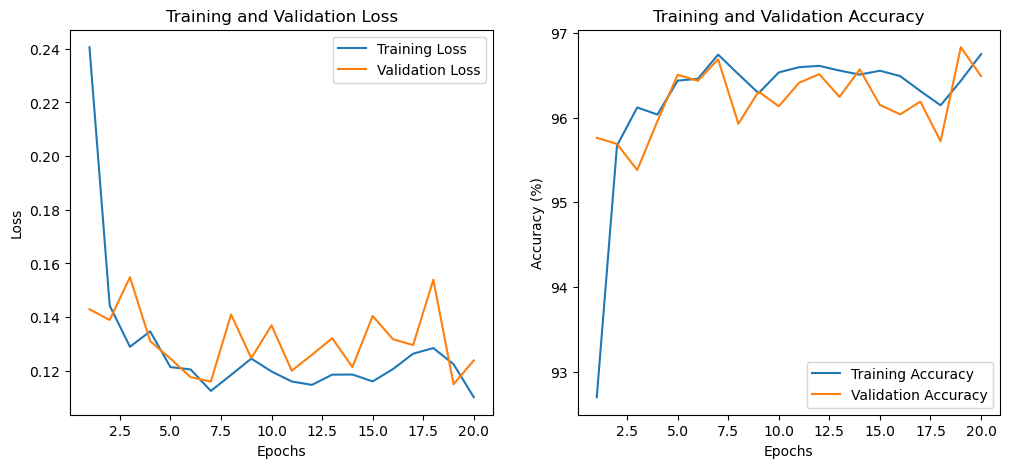


Testing with learning_rate=0.01, batch_size=128
Epoch [1/20], Train Loss: 0.2453, Train Accuracy: 92.50%, Val Loss: 0.1555, Val Accuracy: 95.44%
Epoch [2/20], Train Loss: 0.1248, Train Accuracy: 96.24%, Val Loss: 0.1132, Val Accuracy: 96.73%
Epoch [3/20], Train Loss: 0.1008, Train Accuracy: 96.95%, Val Loss: 0.1116, Val Accuracy: 96.66%
Epoch [4/20], Train Loss: 0.0924, Train Accuracy: 97.19%, Val Loss: 0.1047, Val Accuracy: 96.97%
Epoch [5/20], Train Loss: 0.0925, Train Accuracy: 97.19%, Val Loss: 0.0940, Val Accuracy: 97.27%
Epoch [6/20], Train Loss: 0.0847, Train Accuracy: 97.44%, Val Loss: 0.0974, Val Accuracy: 97.14%
Epoch [7/20], Train Loss: 0.0849, Train Accuracy: 97.48%, Val Loss: 0.0849, Val Accuracy: 97.53%
Epoch [8/20], Train Loss: 0.0794, Train Accuracy: 97.54%, Val Loss: 0.1069, Val Accuracy: 96.73%
Epoch [9/20], Train Loss: 0.0849, Train Accuracy: 97.47%, Val Loss: 0.0883, Val Accuracy: 97.30%
Epoch [10/20], Train Loss: 0.0816, Train Accuracy: 97.63%, Val Loss: 0.0895, V

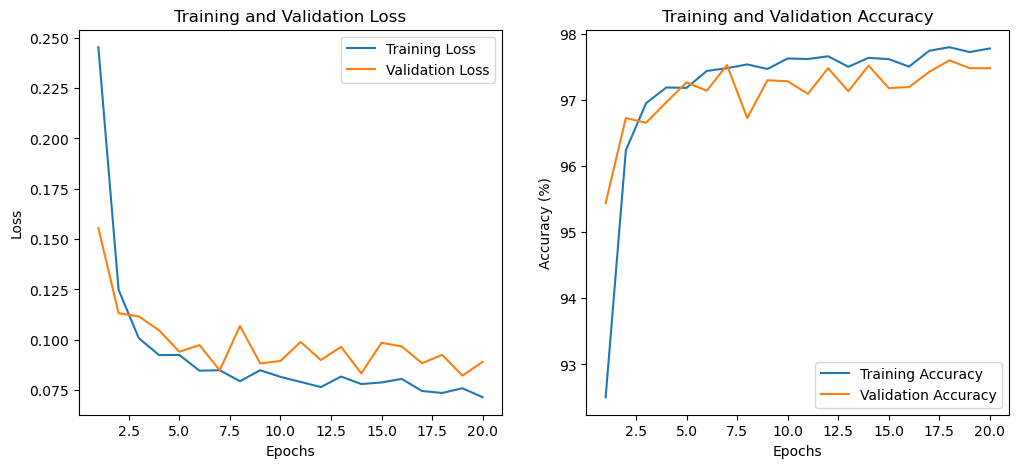


Testing with learning_rate=0.001, batch_size=32
Epoch [1/20], Train Loss: 0.2706, Train Accuracy: 91.83%, Val Loss: 0.1303, Val Accuracy: 95.96%
Epoch [2/20], Train Loss: 0.1020, Train Accuracy: 96.87%, Val Loss: 0.0906, Val Accuracy: 97.17%
Epoch [3/20], Train Loss: 0.0698, Train Accuracy: 97.83%, Val Loss: 0.0651, Val Accuracy: 97.93%
Epoch [4/20], Train Loss: 0.0530, Train Accuracy: 98.32%, Val Loss: 0.0577, Val Accuracy: 98.23%
Epoch [5/20], Train Loss: 0.0397, Train Accuracy: 98.71%, Val Loss: 0.0753, Val Accuracy: 97.49%
Epoch [6/20], Train Loss: 0.0333, Train Accuracy: 98.94%, Val Loss: 0.0543, Val Accuracy: 98.36%
Epoch [7/20], Train Loss: 0.0285, Train Accuracy: 99.09%, Val Loss: 0.0513, Val Accuracy: 98.56%
Epoch [8/20], Train Loss: 0.0239, Train Accuracy: 99.21%, Val Loss: 0.0490, Val Accuracy: 98.65%
Epoch [9/20], Train Loss: 0.0186, Train Accuracy: 99.39%, Val Loss: 0.0621, Val Accuracy: 98.24%
Epoch [10/20], Train Loss: 0.0166, Train Accuracy: 99.48%, Val Loss: 0.0462, V

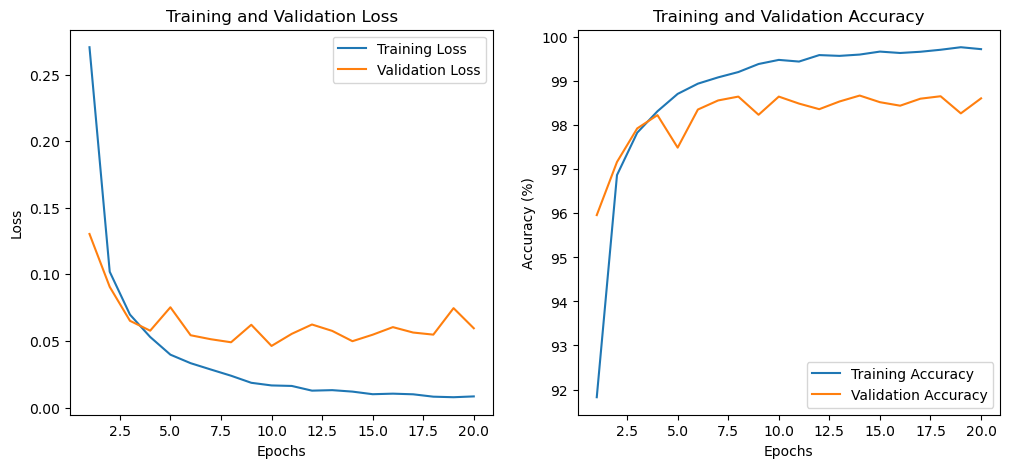


Testing with learning_rate=0.001, batch_size=64
Epoch [1/20], Train Loss: 0.3204, Train Accuracy: 90.82%, Val Loss: 0.1523, Val Accuracy: 95.32%
Epoch [2/20], Train Loss: 0.1088, Train Accuracy: 96.59%, Val Loss: 0.1037, Val Accuracy: 96.85%
Epoch [3/20], Train Loss: 0.0726, Train Accuracy: 97.75%, Val Loss: 0.0791, Val Accuracy: 97.62%
Epoch [4/20], Train Loss: 0.0552, Train Accuracy: 98.29%, Val Loss: 0.0620, Val Accuracy: 98.21%
Epoch [5/20], Train Loss: 0.0433, Train Accuracy: 98.60%, Val Loss: 0.0603, Val Accuracy: 98.13%
Epoch [6/20], Train Loss: 0.0346, Train Accuracy: 98.93%, Val Loss: 0.0521, Val Accuracy: 98.36%
Epoch [7/20], Train Loss: 0.0291, Train Accuracy: 99.06%, Val Loss: 0.0533, Val Accuracy: 98.32%
Epoch [8/20], Train Loss: 0.0244, Train Accuracy: 99.22%, Val Loss: 0.0532, Val Accuracy: 98.40%
Epoch [9/20], Train Loss: 0.0197, Train Accuracy: 99.38%, Val Loss: 0.0559, Val Accuracy: 98.55%
Epoch [10/20], Train Loss: 0.0179, Train Accuracy: 99.41%, Val Loss: 0.0551, V

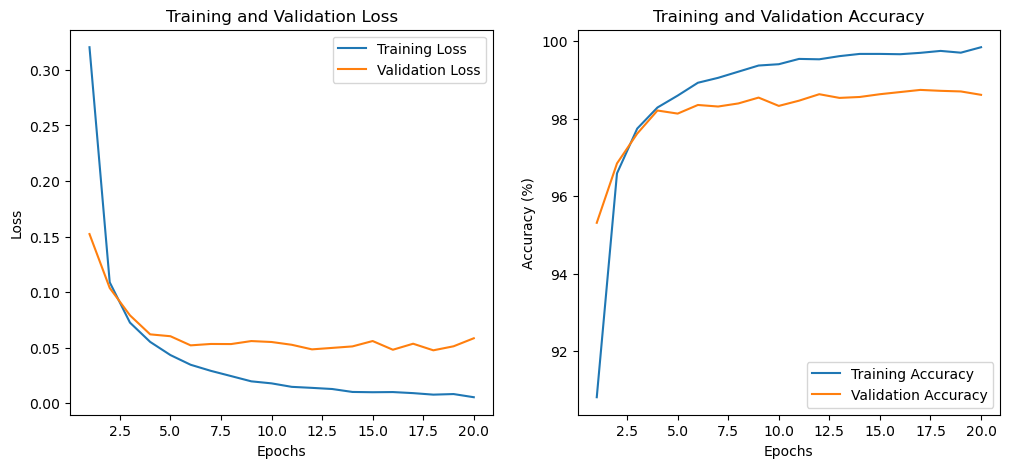


Testing with learning_rate=0.001, batch_size=128
Epoch [1/20], Train Loss: 0.4315, Train Accuracy: 88.02%, Val Loss: 0.1883, Val Accuracy: 94.36%
Epoch [2/20], Train Loss: 0.1384, Train Accuracy: 95.77%, Val Loss: 0.1160, Val Accuracy: 96.50%
Epoch [3/20], Train Loss: 0.0899, Train Accuracy: 97.21%, Val Loss: 0.0869, Val Accuracy: 97.29%
Epoch [4/20], Train Loss: 0.0689, Train Accuracy: 97.79%, Val Loss: 0.0752, Val Accuracy: 97.63%
Epoch [5/20], Train Loss: 0.0529, Train Accuracy: 98.32%, Val Loss: 0.0641, Val Accuracy: 97.99%
Epoch [6/20], Train Loss: 0.0427, Train Accuracy: 98.68%, Val Loss: 0.0671, Val Accuracy: 98.02%
Epoch [7/20], Train Loss: 0.0338, Train Accuracy: 98.96%, Val Loss: 0.0643, Val Accuracy: 98.04%
Epoch [8/20], Train Loss: 0.0282, Train Accuracy: 99.13%, Val Loss: 0.0574, Val Accuracy: 98.34%
Epoch [9/20], Train Loss: 0.0255, Train Accuracy: 99.20%, Val Loss: 0.0581, Val Accuracy: 98.27%
Epoch [10/20], Train Loss: 0.0209, Train Accuracy: 99.37%, Val Loss: 0.0529, 

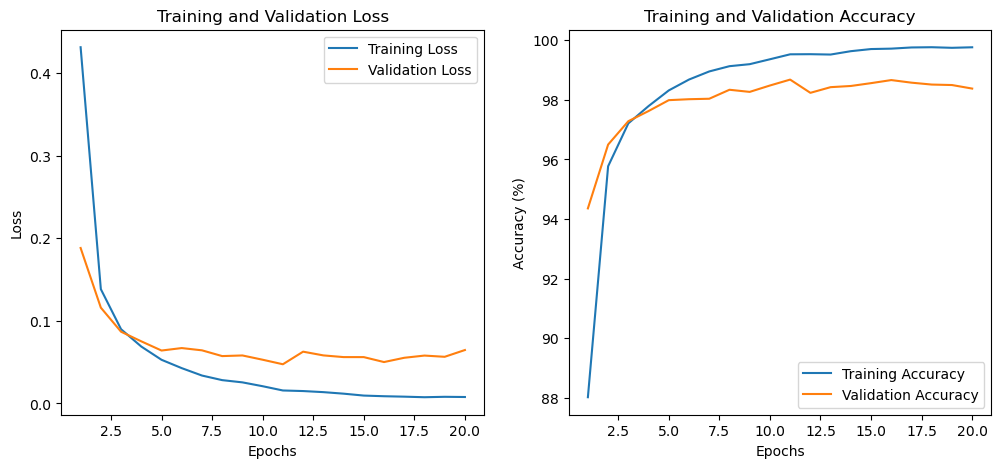


Testing with learning_rate=0.0001, batch_size=32
Epoch [1/20], Train Loss: 0.7142, Train Accuracy: 80.82%, Val Loss: 0.3570, Val Accuracy: 89.55%
Epoch [2/20], Train Loss: 0.2812, Train Accuracy: 91.74%, Val Loss: 0.2557, Val Accuracy: 92.33%
Epoch [3/20], Train Loss: 0.2103, Train Accuracy: 93.71%, Val Loss: 0.1971, Val Accuracy: 93.94%
Epoch [4/20], Train Loss: 0.1650, Train Accuracy: 95.03%, Val Loss: 0.1571, Val Accuracy: 94.98%
Epoch [5/20], Train Loss: 0.1337, Train Accuracy: 96.04%, Val Loss: 0.1309, Val Accuracy: 95.80%
Epoch [6/20], Train Loss: 0.1121, Train Accuracy: 96.68%, Val Loss: 0.1117, Val Accuracy: 96.56%
Epoch [7/20], Train Loss: 0.0957, Train Accuracy: 97.09%, Val Loss: 0.0981, Val Accuracy: 96.87%
Epoch [8/20], Train Loss: 0.0835, Train Accuracy: 97.48%, Val Loss: 0.0892, Val Accuracy: 97.22%
Epoch [9/20], Train Loss: 0.0742, Train Accuracy: 97.81%, Val Loss: 0.0806, Val Accuracy: 97.56%
Epoch [10/20], Train Loss: 0.0662, Train Accuracy: 98.01%, Val Loss: 0.0746, 

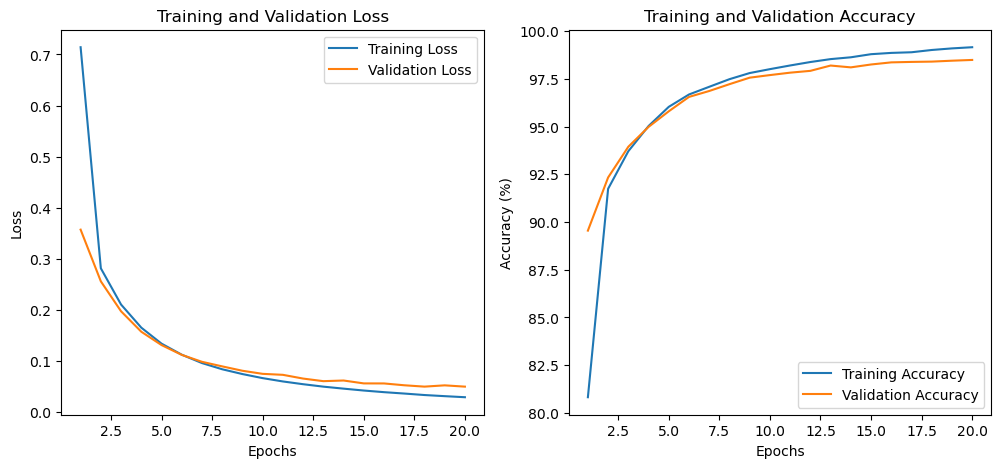


Testing with learning_rate=0.0001, batch_size=64
Epoch [1/20], Train Loss: 0.9597, Train Accuracy: 76.78%, Val Loss: 0.4600, Val Accuracy: 87.97%
Epoch [2/20], Train Loss: 0.3526, Train Accuracy: 90.39%, Val Loss: 0.3145, Val Accuracy: 90.92%
Epoch [3/20], Train Loss: 0.2637, Train Accuracy: 92.51%, Val Loss: 0.2525, Val Accuracy: 92.40%
Epoch [4/20], Train Loss: 0.2151, Train Accuracy: 93.68%, Val Loss: 0.2105, Val Accuracy: 93.63%
Epoch [5/20], Train Loss: 0.1801, Train Accuracy: 94.70%, Val Loss: 0.1819, Val Accuracy: 94.40%
Epoch [6/20], Train Loss: 0.1535, Train Accuracy: 95.46%, Val Loss: 0.1560, Val Accuracy: 95.25%
Epoch [7/20], Train Loss: 0.1336, Train Accuracy: 96.00%, Val Loss: 0.1359, Val Accuracy: 95.69%
Epoch [8/20], Train Loss: 0.1174, Train Accuracy: 96.54%, Val Loss: 0.1222, Val Accuracy: 96.03%
Epoch [9/20], Train Loss: 0.1044, Train Accuracy: 96.87%, Val Loss: 0.1091, Val Accuracy: 96.60%
Epoch [10/20], Train Loss: 0.0938, Train Accuracy: 97.23%, Val Loss: 0.0987, 

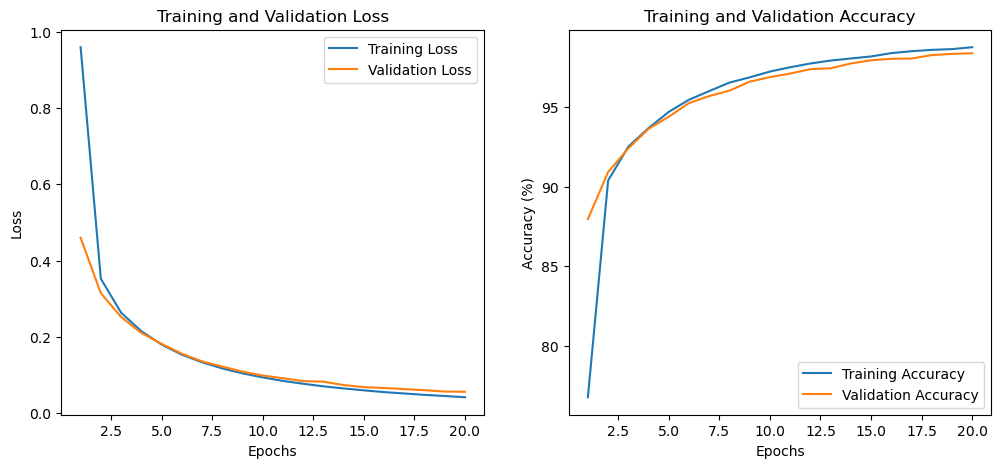


Testing with learning_rate=0.0001, batch_size=128
Epoch [1/20], Train Loss: 1.3309, Train Accuracy: 68.63%, Val Loss: 0.6719, Val Accuracy: 83.68%
Epoch [2/20], Train Loss: 0.4923, Train Accuracy: 87.70%, Val Loss: 0.4165, Val Accuracy: 88.52%
Epoch [3/20], Train Loss: 0.3494, Train Accuracy: 90.31%, Val Loss: 0.3351, Val Accuracy: 90.21%
Epoch [4/20], Train Loss: 0.2883, Train Accuracy: 91.70%, Val Loss: 0.2851, Val Accuracy: 91.46%
Epoch [5/20], Train Loss: 0.2478, Train Accuracy: 92.74%, Val Loss: 0.2477, Val Accuracy: 92.52%
Epoch [6/20], Train Loss: 0.2166, Train Accuracy: 93.61%, Val Loss: 0.2177, Val Accuracy: 93.25%
Epoch [7/20], Train Loss: 0.1911, Train Accuracy: 94.31%, Val Loss: 0.1957, Val Accuracy: 93.96%
Epoch [8/20], Train Loss: 0.1712, Train Accuracy: 94.90%, Val Loss: 0.1759, Val Accuracy: 94.58%
Epoch [9/20], Train Loss: 0.1538, Train Accuracy: 95.39%, Val Loss: 0.1605, Val Accuracy: 94.98%
Epoch [10/20], Train Loss: 0.1401, Train Accuracy: 95.82%, Val Loss: 0.1460,

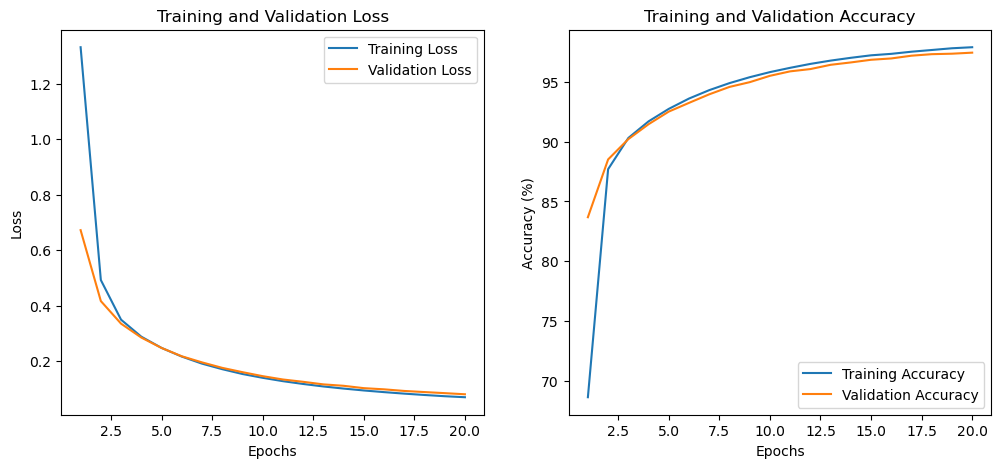


Grid Search Results:
Results for each configuration:
lr=0.01, batch_size=32: 94.65%
lr=0.01, batch_size=64: 96.49%
lr=0.01, batch_size=128: 97.48%
lr=0.001, batch_size=32: 98.61%
lr=0.001, batch_size=64: 98.62%
lr=0.001, batch_size=128: 98.38%
lr=0.0001, batch_size=32: 98.49%
lr=0.0001, batch_size=64: 98.38%
lr=0.0001, batch_size=128: 97.44%

Best validation accuracy: 98.62%
Best hyperparameters: {'learning_rate': 0.001, 'batch_size': 64}


In [155]:
# 1. Perform grid search
results, best_hyperparams = grid_search_lenet()

## Model Analysis and Visualization

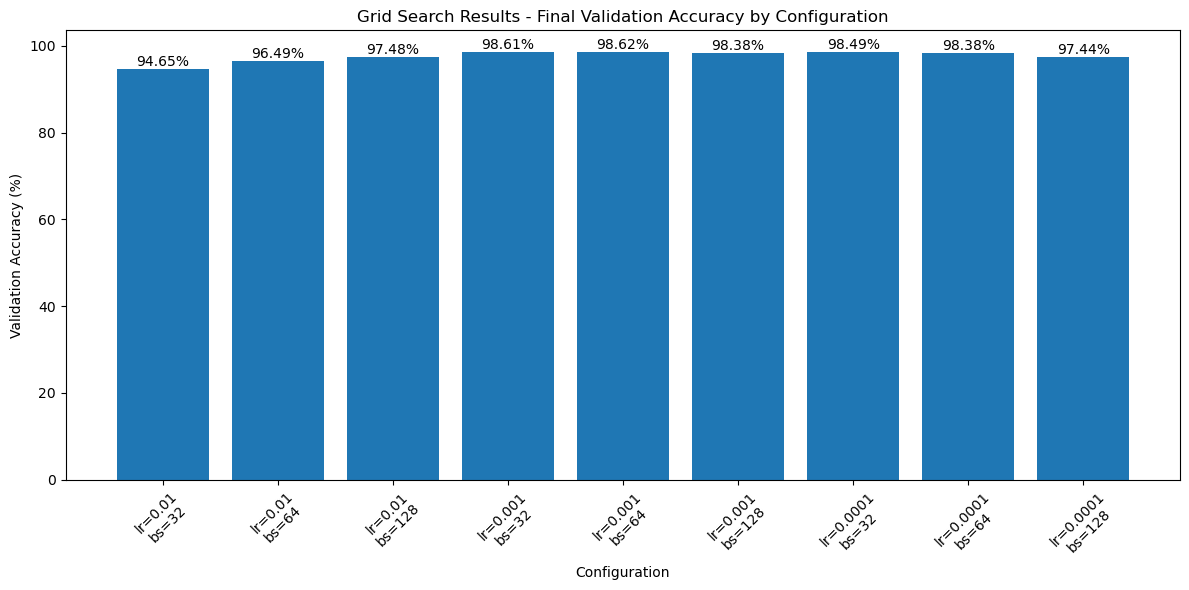

In [158]:
# Create lists for plotting
configs = [f"lr={r['lr']}\nbs={r['batch_size']}" for r in results]
accuracies = [r['final_val_accuracy'] for r in results]

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results)), accuracies)

# Customize plot
plt.xticks(range(len(results)), configs, rotation=45)
plt.xlabel('Configuration')
plt.ylabel('Validation Accuracy (%)')
plt.title('Grid Search Results - Final Validation Accuracy by Configuration')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

## Model Training with Optimized Hyperparameters

In [166]:
def train_final_model(best_hyperparams):
    print("\nTraining final model with best hyperparameters...")
    
    # Load data
    train_dataset, val_dataset, test_dataset = load_data()
    train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    Test_model = LeNet5().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(Test_model.parameters(), lr=best_hyperparams['learning_rate'])
    
    # Train model for more epochs
    train_model(Test_model, train_loader, val_loader, criterion, optimizer, num_epochs=30)
    torch.save(Test_model.state_dict(), 'best_lenet_model.pth')
    # Evaluate on test set
    test_loss, test_accuracy = evaluate_model(Test_model, test_loader, criterion, device)
    print(f"\nTest set performance:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.2f}%")
    
    return Test_model, test_accuracy


Training final model with best hyperparameters...
Epoch [1/30], Train Loss: 0.3338, Train Accuracy: 90.10%, Val Loss: 0.1414, Val Accuracy: 95.88%
Epoch [2/30], Train Loss: 0.1070, Train Accuracy: 96.70%, Val Loss: 0.0920, Val Accuracy: 97.26%
Epoch [3/30], Train Loss: 0.0690, Train Accuracy: 97.88%, Val Loss: 0.0741, Val Accuracy: 97.80%
Epoch [4/30], Train Loss: 0.0523, Train Accuracy: 98.39%, Val Loss: 0.0616, Val Accuracy: 98.20%
Epoch [5/30], Train Loss: 0.0417, Train Accuracy: 98.71%, Val Loss: 0.0589, Val Accuracy: 98.24%
Epoch [6/30], Train Loss: 0.0331, Train Accuracy: 98.98%, Val Loss: 0.0581, Val Accuracy: 98.11%
Epoch [7/30], Train Loss: 0.0284, Train Accuracy: 99.12%, Val Loss: 0.0561, Val Accuracy: 98.36%
Epoch [8/30], Train Loss: 0.0241, Train Accuracy: 99.26%, Val Loss: 0.0518, Val Accuracy: 98.62%
Epoch [9/30], Train Loss: 0.0196, Train Accuracy: 99.40%, Val Loss: 0.0574, Val Accuracy: 98.37%
Epoch [10/30], Train Loss: 0.0174, Train Accuracy: 99.42%, Val Loss: 0.0540,

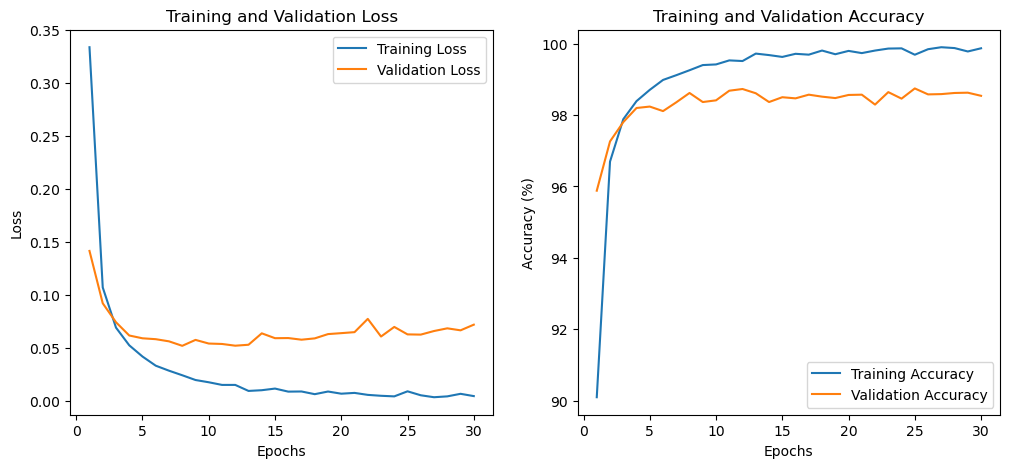


Test set performance:
Loss: 0.0666
Accuracy: 98.66%


In [168]:
# 3. Train final model with best hyperparameters
final_model, test_accuracy = train_final_model(best_hyperparams)

## Model Inference on External Data

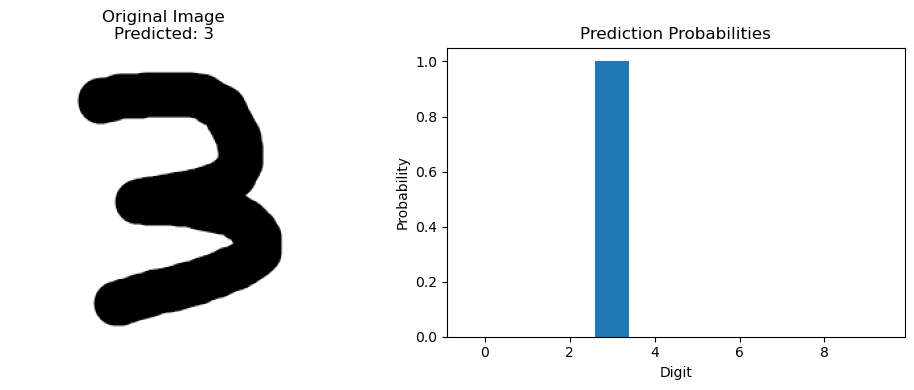

In [178]:
model_path='best_lenet_model.pth'
image_path= 'test_num.png'
# Load and prepare image
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x)  # Invert colors if needed
])

# Load and transform image
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Make prediction
with torch.no_grad():
    image_tensor = image_tensor.to(device)
    output = model(image_tensor)
    _, predicted = torch.max(output.data, 1)
    probabilities = torch.nn.functional.softmax(output, dim=1)

# Plot results
plt.figure(figsize=(10, 4))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Original Image\nPredicted: {predicted.item()}')
plt.axis('off')

# Plot probabilities
plt.subplot(1, 2, 2)
plt.bar(range(10), probabilities[0].cpu())
plt.title('Prediction Probabilities')
plt.xlabel('Digit')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()